# Topic modelling using latent dirichlet allocation

Topic modeling is a method for unsupervised classification of text, similar to clustering on numeric data, which finds natural groups of items even when we're not sure what we're looking for. Latent Dirichlet allocation (LDA) is a particularly popular method for fitting a topic model.

In this notebook we use the ```gensim``` python package

This notebook follows this tutorial: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
import pandas as pd
import numpy as np
import os
import pathlib

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

from pprint import pprint

import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this

[nltk_data] Downloading package punkt to /home/h02/hbrown/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/data/users/hbrown/conda/envs/nlp/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


### Load dataset with sentiment columns

In [2]:
scratch_dir = pathlib.Path(os.environ['SCRATCH'])
clean_data_fname = 'twitter_data_202207260000_202208010900_clean.csv'

tweet_data = pd.read_csv(scratch_dir / clean_data_fname)

/var/tmp/ipykernel_23542/3541629878.py:4: DtypeWarning: Columns (0,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  tweet_data = pd.read_csv(scratch_dir / clean_data_fname)


### Preprocess data

In [3]:
tweet_data = tweet_data[tweet_data['created_at']!='0']
tweet_data['created_at'] = pd.to_datetime(tweet_data['created_at'], format="%Y-%m-%d %H:%M:%S")

In [4]:
tweet_data['dates'] = tweet_data['created_at'].apply(lambda x: x.date())

In [5]:
tweet_data = tweet_data.dropna()

In [6]:
tweet_data = tweet_data.set_index('created_at')
tweet_data.index.date

array([datetime.date(2022, 7, 26), datetime.date(2022, 7, 26),
       datetime.date(2022, 7, 26), ..., datetime.date(2022, 8, 1),
       datetime.date(2022, 8, 1), datetime.date(2022, 8, 1)], dtype=object)

We work with a reduced subset of the tweet dataset, as this is quite a compute hungry process

In [7]:
reduced_tweet_data = tweet_data[tweet_data.index.date == tweet_data['dates'].unique()[2]]

In [8]:
reduced_tweet_data.shape

(24856, 9)

In [9]:
reduced_tweet_data.head()

,tweet_id,tweet,like_count,quote_count,reply_count,retweet_count,clean,hashtags,dates
created_at,,,,,,,,,
2022-07-28 00:59:53+00:00,1552458788246114304,"President Biden got another win, Chunk &amp; M...",1.0,0.0,0,1,president biden win chunk manchin agree high t...,[],2022-07-28
2022-07-28 00:59:32+00:00,1552458703810560001,@Kobrakie32 @pi_slaught @JDVance1 And that's g...,1.0,0.0,1,0,s bring industry backbecause progressive tende...,[],2022-07-28
2022-07-28 00:59:31+00:00,1552458697078878208,@AZ_Brittney He’s handling one crisis after an...,3.0,0.0,0,0,s handle crisis gas price war inflation covid ...,[],2022-07-28
2022-07-28 00:59:29+00:00,1552458689021259776,@colin_korol You have to watch that climate ch...,4.0,0.0,0,0,watch climate change sneak ya,[],2022-07-28
2022-07-28 00:59:26+00:00,1552458675054313473,Keep telling the climate change hoaxers. Wildf...,1.0,0.0,0,1,tell climate change hoaxer wildfire stop guy s...,[],2022-07-28


Tokenizing is the process of splitting a sentence into a list of elements. These elements may be words, or common phrases

In [10]:
words = reduced_tweet_data['clean'].apply(lambda x: word_tokenize(x))

Bigrams and trigrams are groups of two or three consecutive tokens respatcively. This allows us to identify common phases in our dataset. Strangely, 'climate change', which should occur in almost every single one of our tweets, isn't being identified as a bigram. 

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(words, min_count=10, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[words[0]]])

['president_biden', 'win', 'chunk', 'manchin_agree', 'high', 'taxis', 'rich', 'clean_energy', 'climate', 'changepresident', 'biden', 'democrats', 'donevote', 'blue']


In [12]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [13]:
data_words_bigrams = make_trigrams(words)
data_words_bigrams[0]

['president_biden',
 'win',
 'chunk',
 'manchin_agree',
 'high',
 'taxis',
 'rich',
 'clean_energy',
 'climate',
 'changepresident',
 'biden',
 'democrats',
 'donevote',
 'blue']

### Topic modelling using LDA in gensim 

In [14]:
id2word = corpora.Dictionary(data_words_bigrams)
id2word.filter_extremes(no_below=10, no_above=0.35)
id2word.compactify()
corpus = [id2word.doc2bow(text) for text in data_words_bigrams]

texts = data_words_bigrams

corpus = [id2word.doc2bow(text) for text in texts]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


Build the LDA model

In [15]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

Print the top keywords in each of the topics

In [16]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.025*"people" + 0.017*"need" + 0.013*"new" + 0.009*"stop" + 0.009*"work" + '
  '0.009*"money" + 0.007*"state" + 0.007*"mean" + 0.007*"impact" + '
  '0.007*"government"'),
 (1,
  '0.019*"cause" + 0.017*"podcast" + 0.017*"time" + 0.017*"fight" + '
  '0.016*"real" + 0.016*"year" + 0.014*"use" + 0.014*"act" + '
  '0.013*"manchin_support" + 0.012*"come"'),
 (2,
  '0.021*"bill" + 0.016*"s" + 0.015*"like" + 0.014*"inflation" + 0.013*"think" '
  '+ 0.013*"know" + 0.011*"health_care" + 0.010*"world" + 0.010*"help" + '
  '0.009*"address"')]


Compute the coherence score, which assess how good the topic model has performed by measuring the degree of semantic similarity between high scoring words in the topic. The C_V coherence score falls between 0 and 1. 

In [17]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3648231023203538


### Visualise the topics and keywords within that topic using the pyLDAvis dashboard

In [18]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/data/users/hbrown/conda/envs/nlp/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.357776 -0.030556       1        1  41.576531
0      0.205749 -0.289968       2        1  35.252486
1      0.152027  0.320524       3        1  23.170983, topic_info=                              Term         Freq        Total Category  \
116                         people  1924.000000  1924.000000  Default   
347                           bill  1919.000000  1919.000000  Default   
50                            need  1331.000000  1331.000000  Default   
126                          cause   944.000000   944.000000  Default   
3356                       podcast   880.000000   880.000000  Default   
...                            ...          ...          ...      ...   
77                           today   474.999757   499.138606   Topic3   
1184               manchin_support   629.671754   852.804427   Topic3   
3826          biden_praise_sen_joe   618.943759   838.157621   Topic3   
3827  economy_shrink_president_joe   618.943759   838.157621   Topic3   
3828      package_story_daily_news   618.943759   838.157621   Topic3   

      logprob  loglift  
116   30.0000  30.0000  
347   29.0000  29.0000  
50    28.0000  28.0000  
126   27.0000  27.0000  
3356  26.0000  26.0000  
...       ...      ...  
77    -4.6617   1.4127  
1184  -4.3798   1.1589  
3826  -4.3970   1.1591  
3827  -4.3970   1.1591  
3828  -4.3970   1.1591  

[132 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
413       3  0.998466         2
327       3  0.998246       act
171       1  0.998714    action
475       3  0.998290  actually
566       1  0.998662   address
...     ...       ...       ...
66        1  0.998754       way
148       2  0.997208   weather
340       2  0.998143      work
385       1  0.999118     world
216       3  0.999398      year

[119 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

### Optimize the number of topics 

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=num_topics, 
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=1, limit=12, step=1)

/data/users/hbrown/conda/envs/nlp/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/data/users/hbrown/conda/envs/nlp/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/data/users/hbrown/conda/envs/nlp/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/data/users/hbrown/conda/envs/nlp/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


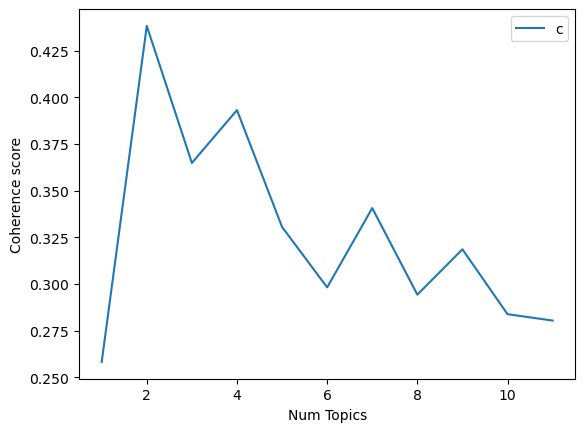

In [20]:
# Show graph
import matplotlib.pyplot as plt
limit=12; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [21]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.2582
Num Topics = 2  has Coherence Value of 0.4383
Num Topics = 3  has Coherence Value of 0.3648
Num Topics = 4  has Coherence Value of 0.3931
Num Topics = 5  has Coherence Value of 0.3305
Num Topics = 6  has Coherence Value of 0.2981
Num Topics = 7  has Coherence Value of 0.3406
Num Topics = 8  has Coherence Value of 0.2942
Num Topics = 9  has Coherence Value of 0.3185
Num Topics = 10  has Coherence Value of 0.2838
Num Topics = 11  has Coherence Value of 0.2803
